# Manutenção de Vias

**Grupo 7:**

- Luís Almeida A84180
- João Pedro Antunes A86813 

## Enunciado e Descrição do Problema

Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 

>  O grafo tem de ser ligado o que significa que entre cada par de nodos $$\langle n_1,n_2 \rangle$$ tem de existir um caminho $$n_1 \leadsto n_2$$ e um caminho $$n_2\leadsto n_1$$

1. Gerar aleatoriamente o grafo. Assuma $N=32$  para o número de nodos. E que cada nodo tem um número aleatório de descendentes no intervalo $1..d$  cujos destinos são também gerados aleatoriamente. Assume-se que não existem “loops” nem repetição de destinos.
    


2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

In [1]:
import random
from z3 import *
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from timeit import timeit
import numpy as np

## Geração de grafos

Para a primeira parte da resolução deste problema, faz-se necessária a geração de grafos randômicos para representar as vias pedidas. Para tanto, utilizaremos grafos orientados no NetworkX, em que os nodos e as arestas e sua direção representarão respectivamente, os pontos de acesso, as vias e seus sentidos únicos como pedido no enunciado.
Temos então de garantir a ligação do grafo, assim como o número de nós e que os nós não tenham mais do que *d* arestas.  

Após a análise de alguns métodos para a criação do grafo com as devidas restrições, concluímos e optamos por um método que não fosse tão dependente de "sorte" para definir sua eficiência, mas que preservasse as propriedades aleatórias de outros métodos que fossem completamente aleatórios (como demonstraremos posteriormente). Assim, começamos por definir as seguintes funções:

In [2]:
def fix_paths(graph,D,N):
    s = set(range(N))
    aux = [x for x in graph]
    random.shuffle(aux)
    for v in aux:
        aux = s.difference({v})
        miss = list(aux.difference(nx.descendants(graph,v)))
        
        while len(graph[v]) < D and len(miss) != 0:
            random.shuffle(miss)
            graph.add_edge(v,miss[0])
            miss = list(aux.difference(nx.descendants(graph,v)))
    pass


def rand_cycle(N):
    aux = list(range(N))
    random.shuffle(aux)
    ed = [(aux[i],aux[i+1]) for i in range(N-1)]
    ed.append((aux[-1],aux[0]))
    G = nx.DiGraph(ed)
    return G
    

A função *fix_paths* busca ao fim de sua execução ter o grafo *graph* o mais completo possível dentre o padrão $D$ definido. Se o grafo já está completo, a função não terá nenhum efeito. Entretanto se um grafo não ligado é passado, a função tentará completá-lo, utilizando a restrição de $D$ como número máximo de arestas de cada vértice, se todos os nós já possuem $D$ arestas ou o grafo está ligado, a função termina. 

Já a função *rand_cycle* gera um ciclo randômico de tamanho $N$.

Estas funções se demonstram responsávis por diminuir o número de "tentativas" do programa para encontrar o grafo procurado.
A *fix_paths* para tentar corrigir grafos previamente gerados de maneira aleatória e a *rand_cycle* para grafos com $D = 1$. 

Definimos, então as demais funções para termos a criação aleatória de grafos:

In [3]:
def gen_graph(N,D):
    if (D == 1):
        graph = rand_cycle(N)
    
    else:
        graph = nx.DiGraph()
        s = set(range(N))
        for v in range(N):
            graph.add_node(v)
    
        for v in graph:
            r = random.randint(1,D)
            aux = s.difference({v})
            descendentes = random.sample(aux,r)
            for d in descendentes:
                graph.add_edge(v,d)
    
        fix_paths(graph,D,N)
    return graph



def random_graph(N,D):
    graph = gen_graph(N,D)
    while not nx.is_strongly_connected(graph):
        graph = gen_graph(N,D)
    return graph


Uma que cria os grafos e tenta corrigí-los através da *fix_paths* e outra que grante que o grafo gerado é sempre um grafo ligado.

Temos assim, grafos gerados aleatóriamente com as dimensões especificadas. Apesar do Problema assumir $N = 32$, assumiremos $N = 40$ para demonstrarmos o potencial do algoritmo desenvolvido.

Is connected? True
Number of Edges: 101


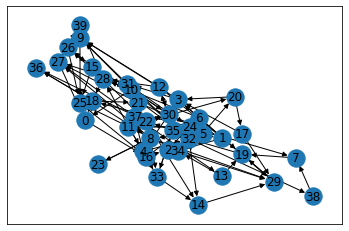

In [28]:
def show_graph(l):
    graph = nx.DiGraph(l)
    print(f"Is connected? {nx.is_strongly_connected(graph)}")
    print(f"Number of Edges: {len(graph.edges())}")
    nx.draw_networkx(graph)
    return

N = 40
D = 3
G  = random_graph(40,4)
show_graph(G)

Falta então demonstrarmos a aleatoriedade do grafo apresentado, considerando a utilização de funções que poderiam tornar a geração "tendenciosa".

Para tanto, demonstrado empiricamente, repliquemos a criação do grafo $10^4$ vezes e façamos um "plot" da densidade de probabilidade de um dado número de arestas total, i.e. um gráfico cujos eixos são a soma total de arestas de uma amostra e o número de amostras que apresentaram a mesma soma. Se o grafo for aleatóriamente gerado, o formato do gráfico deve coincidir com o de uma distribuição normal. E o ponto de simetria da distribuição, i.e., seu valor médio, deve ser:
$$
\mu = \frac{n* (d + 1)}{2}
$$

Desenvolvemos então as seguintes funções para o teste empírico.

Valor médio obtido:35.153962
Valor médio esperado:35.0


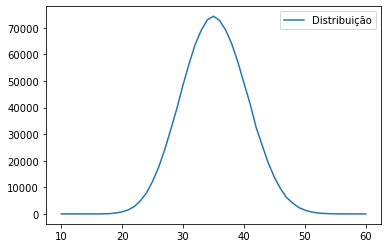

In [15]:
def compareRAND(n, d, reps):
    r = [0]*(n*d - (n-1))
    acc = 0
    

    for i in range(reps):
        G = gen_graph(n,d)
        l = len(G.edges())
        acc += l
        r[l-n] += 1

    print(f"Valor médio obtido:{acc/reps}\nValor médio esperado:{(n)*(d+1)/2}")
    plt.plot(range(n,(n*d)+1),r, label = "Distribuição")
    plt.legend()
    plt.show()
    pass

compareRAND(10,6,10**6)

Garantindo assim a aleatoriedade dos grafos.

## Redução do Grafo


Para a resolução do problema apresntado, temos agora de reduzir o grafo ao menor número possível de arestas que o mantenham ligado. Isto é, remover o maior número de arestas possíveis, mas garantindo que ao fim do processo ainda tenhamos para cada par de nodos um caminho entre eles.

Utilizando-se do $z3$ e o método de minimização de um dado objetivo, o problema torna-se uma questão de após minimizar o número de arestas manter a ligação do grafo.

A estratégia utilizada foi, então, baseada no cálculo de fluxo em um grafo. O objetivo seria para todo vértice do gráfico manter algum fluxo para qualquer outro vértice do grafo que não ele próprio, e utilizando o menor número de arestas possível, das quais as não utilizadas podem ser removidas.

Assim, "quebramos" nosso problema em, inicialmente, manter fluxo a partir de um vértice para todos os outros vértices do grafo que não ele próprio. Replicando para os demais vértices.

Com certa "liberdade" podemos expressar a condição acima com a ilustração em que os vértices do grafo são baldes que comportam $1$ Litro de água, as arestas são canos que não retém líquido, possuem capacidade indeterminada e passam água unidirecionalmente. O vértice em "estudo" seria uma "torneira" que depeja $N-1$ litros de água neste sistema, enchendo todos os baldes. 
Basta então variarmos a posição da torneira por todos os vértices, e teremos a condição de que o grafo é ligado.

A condição acima descrita pode ser feita atribuindo as seguintes variáveis:

 - A variável $f_{n,(o,d)}$ representa a quantidade de "água" (fluxo) que passa na aresta de origem $o$ e destino $d$ para a torneira (vértice estudado) $n$;
 
 
 - $f_{n,(o,d)} \ge 0$, Uma vez que o fluxo é não negativo e unidirecional nas arestas;
 
E para termos o resultado esperado, adicionemos as seguintes restrições:

 - A torneira despeja $N - 1$ litros de água no sistema:

$$
\forall n \cdot \sum_{d} f_{n,(n,d)} = N-1
$$

 - Para todo nó $n$, todo nó $h$ exceto $n$ recebe "água":
$$
\forall n \cdot \forall h \neq n \cdot \sum_{o} f_{n,(o,h)} \ge 1
$$

 - Para todo nó $n$, todo nó $h$ exceto $n$ retem exatamente "1 Litro de água":
 $$
 \forall n \cdot \forall h \neq n \cdot (\sum_{o} f_{n,(o,h)} - \sum_{d} f_{n,(h,d)} = 1)
 $$
 
 
 Com as restrições acima garantidas, temos sempre a certeza que o grafo está devidamente ligado.
 Agora, temos de definir um objetivo a ser minimizado, diminuindo o número de arestas.
 
 Para isso "alocaremos" uma variável $d_{E}$, binária, que indicará se a edge $E$ é utilizada para alguma torneira.
 Assim,
 $$
 0 \le d_{E} \le 1
 $$

e também,

$$
\forall E \cdot (d_{E} = 1 \Leftrightarrow \sum_{n} f_{n,E} \ge 1)
$$
 
Como estamos trabalhando com IP, entretanto, a restrição acima foi modificada, mas mantendo as propriedades indicadas.
Para IP, determinamos uma contante que irá majorar o valor do somatório de $f_{n,E}$, chamemos $C$. Sabendo que o valor máximo de "água" que passa em uma aresta é dado por $N-1$ (o "despejo" original de água), o valor máximo do somatório apresentado será:

$$
\sum_{n} f_{n,E} \le (N - 1)*N
$$

Logo, $ C = (N - 1)*N $.

Definido este majorante, e dado que $$  0 \le d_{E} \le 1 $$ Podemos então adicionar a restrição de:

$$
\exists_{0 \le T < C} \cdot (\sum_{n} f_{n,E} + T = d_{E} * C)
$$

Assim, temos agora em $d_{E}$ o valor binário se a aresta $E$ está sendo utilizada. Basta então minimizarmos o objetivo:

$$
\sum_{E} d_{E}
$$

Obtendo o resultado requerido da dimunição de arestas, mantendo a ligação do grafo.

In [4]:
def removeVias(graph):
    N = [x for x in graph]
    E = [ed for ed in graph.edges()]

    sol = Optimize()
    f = {}
    d = {}
    auxT = {}
    for node in N:
        for ed in E:
            f[node,ed] = Int(str((node,ed)))
            sol.add(f[node,ed] >= 0)

    for src in N: #Toda "torneira" enche todos os "baldes" no grafo
        sol.add(Sum([f[src,ed] for ed in graph.out_edges(src)]) == len(N) - 1) #a "torneira" despeja N-1 L de água
        for tgt in N:
            if src != tgt:
                sol.add(Sum([f[src,ed] for ed in graph.in_edges(tgt)]) >= 1) #cada nó tem chegada de líquido
                sol.add(Sum([f[src,ed] for ed in graph.in_edges(tgt)]) -1 == Sum([f[src,ed] for ed in graph.out_edges(tgt)]))
                #cada nó "armazena" exatamente 1L de água

    n = len(N)
    const = (n-1)*n #majorante do somatório da utilização de edges
    for ed in E:
        d[ed] = Int("mantem" + str(ed))
        auxT[ed] = Int("auxiliar" + str(ed))
        sol.add(d[ed] >= 0, d[ed] <= 1)
        sol.add(auxT[ed] >= 0)
        sol.add(Sum([f[nd,ed] for nd in N]) + auxT[ed] - d[ed]*const == 0) #se o "cano" é usado, mantém-se


    sol.minimize(Sum([d[ed] for ed in E])) #minimiza-se o uso de "canos"
    r = sol.check()
    if r == sat:
        l = []
        m = sol.model()
        for e in d:
            if m[d[e]] == 1:
                l.append(e)
        return l,len(graph.edges()) - m.eval(Sum([d[e] for e in d])).as_long()
    
    return unsat

Apresenta-se então, o resultado obtido para o grafo gerado na secção anterior:

Is connected? True
Number of Edges: 46
Foram removidas 55 vias


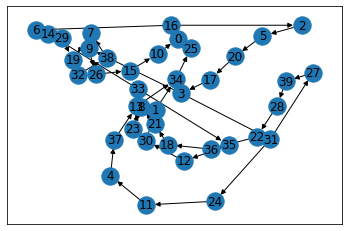

In [29]:
l = removeVias(G)
show_graph(l[0])
print(f"Foram removidas {l[1]} vias")

## Breve análise de Complexidade empírica

Analisando a função de redução desenvolvida e seu comportamento, nota-se que sua complexidade define-se a custa dos inputs passados, $N$ e $D$. Entretanto, cabe ainda uma questão de aleatoriedade na complexidade visto que a densidade do grafo é variável consoante sua geração. Para tanto, será feita a análise empírica de maneira a majorar a complexidade da função, removendo o fator aleatório, e realizando a medição com grafos com $N$ nodos dos quais sairão sempre $D$ arestas. Criando, a seguir, um gráfico que contextualize os parâmetros.


Definimos então funções para as devidas medições:

In [10]:
def gen_graphCOMP(N,D):
    if (D == 1):
        graph = rand_cycle(N)
    
    else:
        graph = nx.DiGraph()
        s = set(range(N))
        for v in range(N):
            graph.add_node(v)
    
        for v in graph:
            aux = s.difference({v})
            descendentes = random.sample(aux,D)
            for d in descendentes:
                graph.add_edge(v,d)
    
    return graph


def random_graphCOMP(N,D):
    graph = gen_graphCOMP(N,D)
    while not nx.is_strongly_connected(graph):
        graph = gen_graphCOMP(N,D)
    return graph


G = nx.Graph()

def timerExecs(nMin,nMax,dMin,dMax,reps):
    times = []
    global G
    for n in range(nMin,nMax+1):
        for d in range(dMin,dMax+1):
            if d >= n:
                times.append((d,n,0))

            else:
                t = 0
                for _ in range(reps):
                    G = gen_graphCOMP(n,d)
                    t += timeit(setup=f"from __main__ import G,removeVias", stmt=f"removeVias(G)",number=1)

                times.append((d,n,t/reps))

    x = []
    y = []
    z = []
    #times.reverse()
    for t in times:
        x.append(t[1])
        y.append(t[0])
        z.append(t[2])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(y,x,z, cmap=cm.jet)
    ax.set_ylabel('N')
    ax.set_xlabel('D')
    ax.set_xlim(dMax, dMin)
    ax.set_zlabel('Complexity')
    plt.show()
    pass



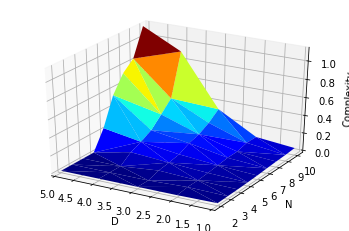

In [11]:
timerExecs(2,10,1,5,6)